In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

file_name = "exponential2_20251029_0928"
groud_truth = lambda x1, x2: np.exp(-2*x1) + x2
# d_opt = pd.read_excel(os.path.join(os.getcwd(), "multkan_sweep_autosave", file_name + ".xlsx"), sheet_name='best_spline_avg_by_params')
d_opt = pd.read_excel(os.path.join(os.getcwd(), "multkan_sweep_autosave", file_name + ".xlsx"), sheet_name='best_avg_by_params')

save_heading = os.path.join(os.getcwd(), "custom_figures", file_name)

x1_grid = np.linspace(-1, 1, 120)
x2_grid = np.linspace(-1, 1, 120)

x1, x2= np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)
y_mesh = groud_truth(x1, x2)

y = y_mesh.flatten().reshape(-1, 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

X_norm = np.concatenate([X_train_norm, X_val_norm, X_test_norm])
y_norm = np.concatenate([y_train_norm, y_val_norm, y_test_norm])


This script is running on cpu.
전체 데이터셋 크기: 14400
훈련셋 크기: 9216 (64.0%)
검증셋 크기: 2304 (16.0%)
테스트셋 크기: 2880 (20.0%)


In [2]:
from SALib.analyze.sobol import analyze

nx = X_norm.shape[1]
problem = {
    'num_vars': nx,
    'names': [f'x{i+1}' for i in range(nx)],
    'bounds': [[0.1, 0.9]] * nx
}
y_norm_flat = y_norm.flatten()
Si = analyze(problem, y_norm_flat, print_to_console=True)

          ST   ST_conf
x1  1.029740  0.057687
x2  1.004789  0.059956
          S1   S1_conf
x1 -0.044816  0.053922
x2 -0.030148  0.060088
                S2   S2_conf
[x1, x2]  0.073611  0.084682


In [6]:
from SALib.sample import sobol

x_saltelli = sobol.sample(problem, 2048)
x_descaled_saltelli = scaler_X.inverse_transform(x_saltelli)
y_descaled_satelli = groud_truth(x_descaled_saltelli[:, 0], x_descaled_saltelli[:, 1])
y_satelli = scaler_y.transform(y_descaled_satelli.reshape(-1, 1)).reshape(-1)
Si_satelli = analyze(problem, y_satelli, print_to_console=True)

          ST   ST_conf
x1  0.913809  0.038596
x2  0.086193  0.005668
          S1   S1_conf
x1  0.913821  0.058262
x2  0.086188  0.016900
                S2   S2_conf
[x1, x2] -0.000025  0.096299


In [8]:
from SALib.sample import latin

x_latin = latin.sample(problem, 14400)
x_descaled_latin = scaler_X.inverse_transform(x_latin)
y_descaled_latin = groud_truth(x_descaled_latin[:, 0], x_descaled_latin[:, 1])
y_latin = scaler_y.transform(y_descaled_latin.reshape(-1, 1)).reshape(-1)
Si_latin = analyze(problem, y_latin, print_to_console=True)

          ST   ST_conf
x1  1.023687  0.066820
x2  0.982671  0.058757
          S1   S1_conf
x1 -0.001483  0.053658
x2  0.024679  0.052922
                S2   S2_conf
[x1, x2] -0.038691  0.074878


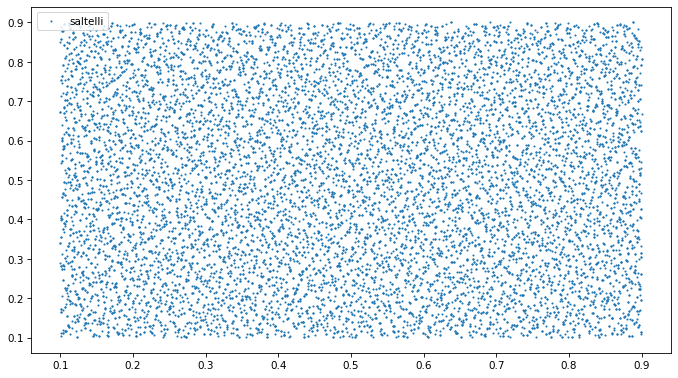

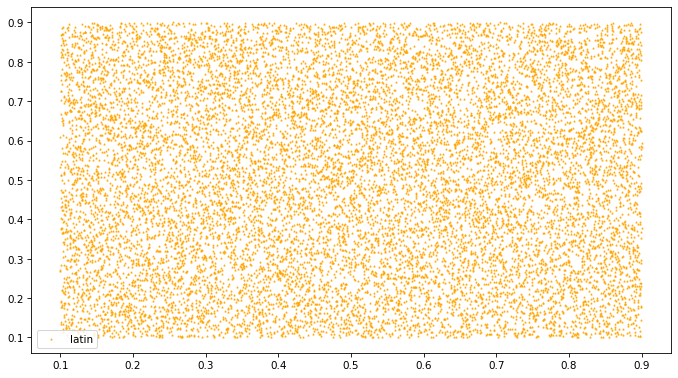

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x_saltelli[:, 0], x_saltelli[:, 1], marker='o', s=1, label='saltelli')
plt.legend()
plt.show()

plt.scatter(x_latin[:, 0], x_latin[:, 1], marker='^', color='orange', s=1, label='latin')
plt.legend()
plt.show()

Latin sampling 이 오히려 갯수도 많고 더 흩뿌려져 있음.
그런데 Sobol total index (ST) 결과를 보면 Saltelli (Sobol) sampling이 더 현상을 잘 파악한 것으로 보임.


Sensitivity analysis 는 그저 분산을 계산하는 방법만이 아니라 그 데이터 자체를 뽑는 DoE 까지 포함하고 있다. 그렇다면 DoE를 처음부터 계획하지 못한 채, 이미 주어진 데이터 셋을 가지고 분석해야 하는 경우에는 KAN이 상대적인 우위를 갖는다.